# Обзор систематик

[Systematic errors](https://www.annualreviews.org/doi/pdf/10.1146/annurev.nucl.57.090506.123052)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
def calc_cs_born(df):
    cs_born = df['n_sig_exp']/(df['lum']*df['eff0']*df['eff_trig']*df['rad']*df['dccorr'])
    cs_born_err = cs_born*df['rad']*np.sqrt( (df['n_sig_exp_err']/df['n_sig_exp'])**2 +
        (df['lum_err']/df['lum'])**2 + (df['eff0_err']/df['eff0'])**2 + (df['eff_trig_err']/df['eff_trig'])**2 + 
                                           (df['dccorr_err']/df['dccorr'])**2) #не делю на рад.поправку
    return (cs_born, cs_born_err)
def get_cs(season, dropna=False):
    df_signal = pd.read_csv(f'../data/{season}/results/signal.csv', index_col=0)
    df_reg_eff = pd.read_csv(f'../data/{season}/results/reg_eff.csv', index_col=0)
    df_triggers = pd.read_csv(f'../data/{season}/results/triggers.csv', index_col=0)
    df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{season}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
    df_dc = pd.read_csv(f'../data/{season}/results/dc_n2.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/dc_n2.csv') else pd.DataFrame({'dccorr': 1, 'dccorr_err': 0}, index=df_signal.index)
    df_rads = pd.read_csv(f'../data/{season}/results/radcors_n.csv', index_col=0) \
        if os.path.isfile(f'../data/{season}/results/radcors_n.csv') else pd.DataFrame({'rad': 1, 'rad_err': 0}, index=df_signal.index)
    df = pd.concat([df_signal, df_reg_eff, df_triggers, df_lum, df_dc, df_rads], axis=1)
    df.rad.fillna(1, inplace=True)
    df.rad_err.fillna(0, inplace=True)
    df['cs_born'], df['cs_born_err'] = calc_cs_born(df)
    df['season'] = season
    if dropna:
        df.dropna(inplace=True)
    return df

## Посмотрю на то, что у меня есть

In [4]:
SEASONS = ['11', '12', '17', '19', '20']
cs = {s: get_cs(s, True) for s in SEASONS}

### Статистическая ошибка числа событий

Stat Error season 11: mean 23.3%, median 18.0%
Stat Error season 12: mean 25.4%, median 24.1%
Stat Error season 17: mean 27.5%, median 26.7%
Stat Error season 19: mean 20.6%, median 13.2%
Stat Error season 20: mean 13.7%, median 13.5%


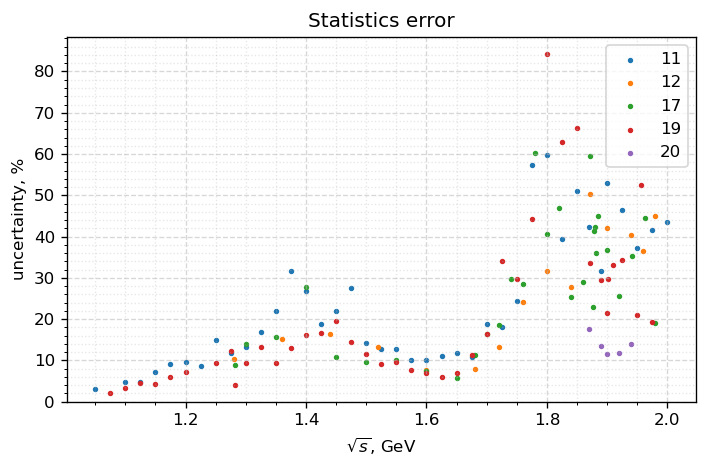

In [5]:
for s in cs:
    stat_err = cs[s]['n_sig_exp_err']/cs[s]['n_sig_exp']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'Stat Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('Statistics error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### Триггеры
Как оценить систематику от корреляций?

Trig Error season 11: mean 6.7%, median 4.2%
Trig Error season 12: mean 4.2%, median 3.6%
Trig Error season 17: mean 2.1%, median 1.4%
Trig Error season 19: mean 0.4%, median 0.2%
Trig Error season 20: mean 0.1%, median 0.1%


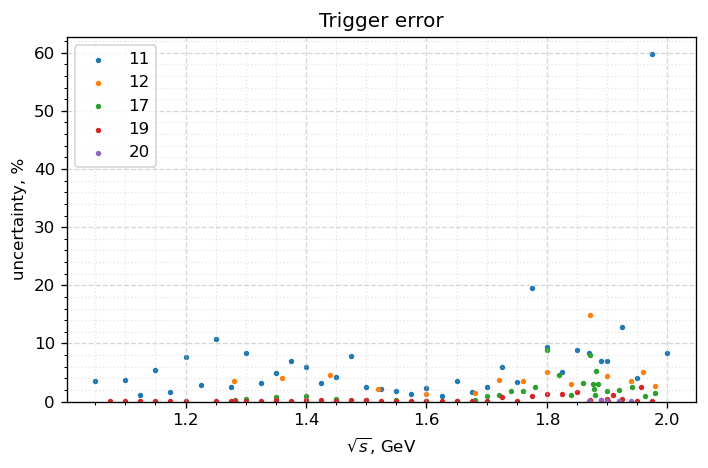

In [6]:
for s in cs:
    stat_err = cs[s]['eff_trig_err']/cs[s]['eff_trig']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'Trig Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('Trigger error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### MC

MC Error season 11: mean 4.4%, median 4.4%
MC Error season 12: mean 5.1%, median 5.0%
MC Error season 17: mean 5.3%, median 5.2%
MC Error season 19: mean 4.6%, median 4.5%
MC Error season 20: mean 7.0%, median 6.5%


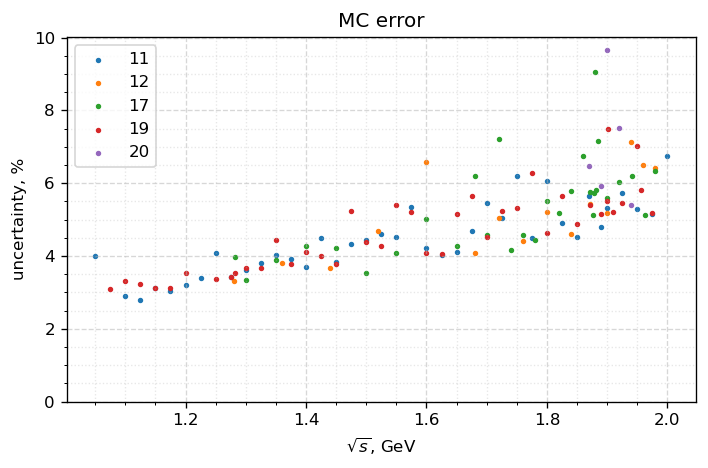

In [7]:
for s in cs:
    stat_err = cs[s]['eff0_err']/cs[s]['eff0']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'MC Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('MC error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### DC corr

MC Error season 11: mean 5.0%, median 5.0%
MC Error season 12: mean 9.2%, median 9.2%
MC Error season 17: mean 5.9%, median 5.9%
MC Error season 19: mean 3.2%, median 3.2%
MC Error season 20: mean 12.7%, median 12.8%


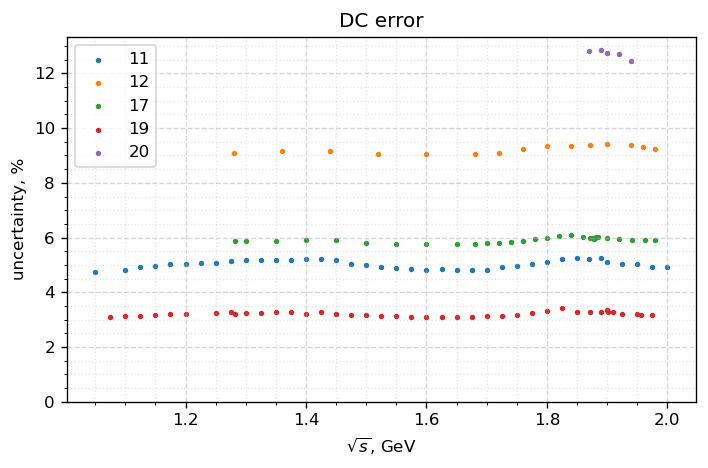

In [36]:
for s in cs:
    stat_err = cs[s]['dccorr_err']/cs[s]['dccorr']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'MC Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('DC error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### Светимость (статистическая ошибка светимости?)

MC Error season 11: mean 0.3%, median 0.3%
MC Error season 12: mean 0.3%, median 0.3%
MC Error season 17: mean 0.2%, median 0.2%
MC Error season 19: mean 0.2%, median 0.2%
MC Error season 20: mean 0.1%, median 0.1%


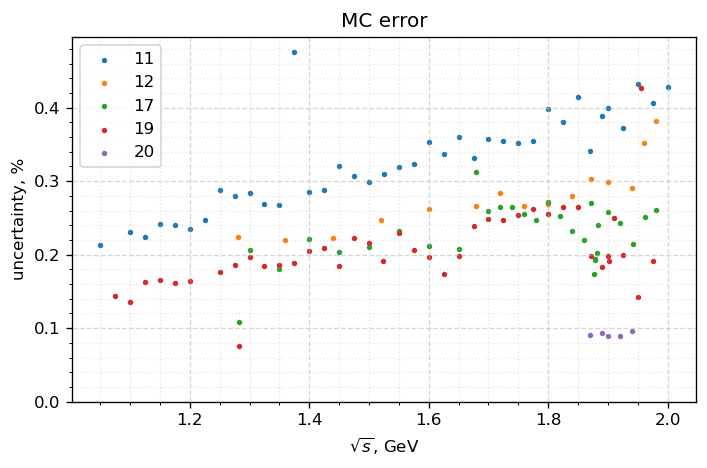

In [9]:
for s in cs:
    stat_err = cs[s]['lum_err']/cs[s]['lum']
    plt.scatter(stat_err.index*2e-3, stat_err*100, label=s, marker='.', s=20)
    print(f'MC Error season {s}: mean {stat_err.mean()*100:.1f}%, median {stat_err.median()*100:.1f}%')
pys.my_style('MC error', '$\sqrt{s}$, GeV', 'uncertainty, %', legend=True, ylim=(0, None))

### Рад. поправки
Вопрос, как оценить ошибку радпоправок, т.к. в ней сидит эффективность, все параметры которой имеют ошибки, да ещё и ошибки соседних точек при аппроксимации

### Критерии отбора
Варьировать отборы, посмотреть влияние

### Ошибки определения числа событий
Посмотреть разные фиты для фона (константа, линия, полином)


In [3]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM

def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 2*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

def cutter_tree(df, z_cut, align_cut):
    df2 = df.loc[(np.abs(df['tz[0]'])<z_cut)&(np.abs(df['tz[1]'])<z_cut)&(df['ksalign']>align_cut)].copy()
    return df2

In [16]:
from progressbar import progressbar

In [12]:
def rand_sys(SEASON, max_samples=4, poly_deg=[0, 1],
             z_var=[10, 12, 14], align_var=[0.7, 0.8, 0.85], 
             xmin_var=[-45, -40, -30], xmax_var=[15, 20, 25]):
    exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
    mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
    df_exp0 = preprocess.read_tree(exp_tree, mc=False, z_cut=max(z_var), align_cut=min(align_var))
    df_mc0 = preprocess.read_tree(mc_tree, mc=True, z_cut=max(z_var), align_cut=min(align_var))
    sampler = lambda x: np.random.choice(x, max_samples)
    samps = {'z' : sampler(z_var),
             'align' : sampler(align_var),
             'xmin' : sampler(xmin_var),
             'xmax' : sampler(xmax_var),
             'polynom' : sampler(poly_deg),
            }
    samples = np.unique(np.concatenate([samps[s].reshape(1, -1) for s in samps]), axis=1).T
    inference = pd.DataFrame(columns=[f'sample_{i+1}' for i in range(len(samples))])
    
    print(f'Number of samples: {len(samples)}')
    for i, sample in enumerate(samples):
        samp_dict = dict(zip(samps.keys(), sample))
        print(f'{i+1:2} Sample', samp_dict)
        
        df_exp = cutter_tree(df_exp0, samp_dict['z'], samp_dict['align'])
        df_mc = cutter_tree(df_mc0, samp_dict['z'], samp_dict['align'])
        
        energies_list = df_exp.index.unique().intersection(df_mc.index.unique())
        
        fit_range = (samp_dict['xmin'], samp_dict['xmax'])
        params = {
            'n_sig': (2000, (0.1, None)),
            'm'    : (   0, (-5, 5)),
            'sL'   : (   2, (1, 10)),
            'sR'   : (   5, (1, 10)),
            'aL'   : (   0, (0, 10)),
            'aR'   : (   0, (0, 10)),
            'y0'   : (   0.1, (0, None)),
            'dy'   : (   0.1, (0, None)),
        }
        
        for energy in energies_list:
#             print(f'Fitting {SEASON} | {energy} MeV')
            dfE, dfM = get_x1(df_exp, df_mc, energy)
            dataE, dataM = dfE.x1.values, dfM.x1.values
            
            m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
            m_mc.simplex().migrad(iterate=20).hesse()
            if not(m_mc.valid):
                print(f'MC FIT NOT VALID')

            params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
            if samp_dict['polynom']<0.1:
                params_exp['dy'] = (0., (0, 0))
            elif samp_dict['polynom']<1.1:
                params_exp['dy'] = (0.3, (0, None))
            m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
            try:
                m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse()
                if not(m_exp.valid):
                    print(f'EXP FIT NOT VALID')
                inference.at[energy, f'sample_{i+1}'] = m_exp.values["n_sig"]/m_mc.values["n_sig"]
            except:
                print('Fit problem')
                inference.at[energy, f'sample_{i+1}'] = np.NAN
                
#             print(f' Exp/MC: {m_exp.values["n_sig"]:8.2f}/{m_mc.values["n_sig"]:8.2f}')
        
    return inference

In [13]:
SEASON = '12'

In [14]:
%%time
sys_errs = rand_sys(SEASON, max_samples=30)

Number of samples: 28
 1 Sample {'z': 10.0, 'align': 0.7, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}
 2 Sample {'z': 10.0, 'align': 0.7, 'xmin': -30.0, 'xmax': 20.0, 'polynom': 1.0}
 3 Sample {'z': 10.0, 'align': 0.7, 'xmin': -30.0, 'xmax': 25.0, 'polynom': 1.0}
Fit problem
 4 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 0.0}
 5 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 20.0, 'polynom': 0.0}
 6 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}
 7 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 0.0}
 8 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 1.0}
 9 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 20.0, 'polynom': 1.0}
10 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}
11 Sample {'z': 10.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 1.0}
12 Sample {'z': 10.0, 'align': 0.85, 'xmin': -30.0, 'xmax': 15.0, 'pol

In [20]:
real = ((cs[SEASON]['n_sig_exp']/cs[SEASON]['n_sig_mc'])/sys_errs.T.mean()).dropna()

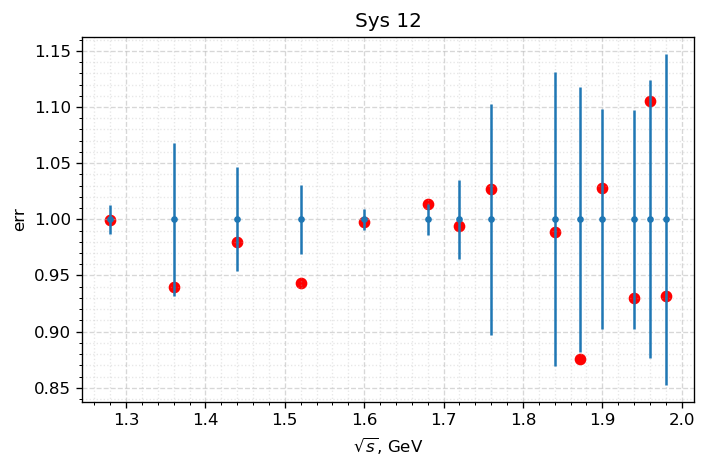

In [21]:
plt.errorbar(sys_errs.index*2e-3, sys_errs.T.mean()/sys_errs.T.mean(), yerr=sys_errs.T.std()/sys_errs.T.mean(), fmt='.')
plt.scatter(real.index*2e-3, real, c='r')
pys.my_style(f'Sys {SEASON}', '$\sqrt{s}$, GeV', 'err');

In [13]:
sys_errs = rand_sys('19', max_samples=10)
real = ((cs['19']['n_sig_exp']/cs['19']['n_sig_mc'])/sys_errs.T.mean()).dropna()

Number of samples: 9
 1 Sample {'z': 10.0, 'align': 0.8, 'xmin': -45.0, 'xmax': 15.0, 'polynom': 1.0}
 2 Sample {'z': 10.0, 'align': 0.8, 'xmin': -40.0, 'xmax': 15.0, 'polynom': 1.0}
 3 Sample {'z': 10.0, 'align': 0.8, 'xmin': -30.0, 'xmax': 15.0, 'polynom': 1.0}
 4 Sample {'z': 10.0, 'align': 0.85, 'xmin': -40.0, 'xmax': 20.0, 'polynom': 0.0}
 5 Sample {'z': 10.0, 'align': 0.85, 'xmin': -30.0, 'xmax': 20.0, 'polynom': 0.0}
 6 Sample {'z': 12.0, 'align': 0.7, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 1.0}
 7 Sample {'z': 12.0, 'align': 0.8, 'xmin': -40.0, 'xmax': 20.0, 'polynom': 1.0}
 8 Sample {'z': 12.0, 'align': 0.8, 'xmin': -30.0, 'xmax': 25.0, 'polynom': 1.0}
 9 Sample {'z': 14.0, 'align': 0.85, 'xmin': -45.0, 'xmax': 25.0, 'polynom': 0.0}


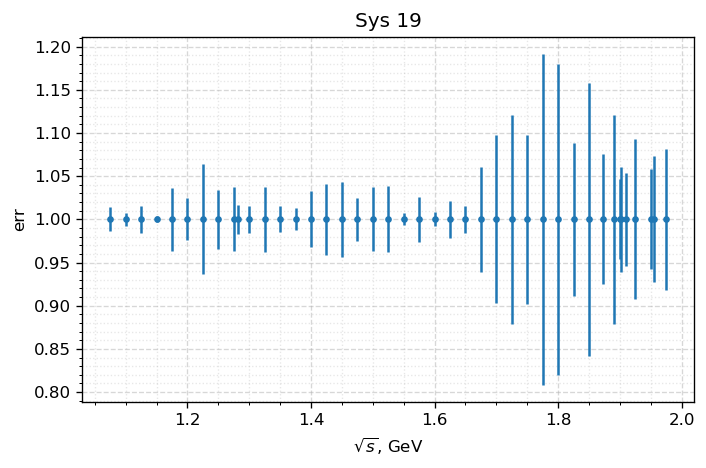

In [41]:
plt.errorbar(sys_errs.index*2e-3, sys_errs.T.mean()/sys_errs.T.mean(), yerr=sys_errs.T.std()/sys_errs.T.mean(), fmt='.')
# plt.scatter(real.index*2e-3, real, c='r')
pys.my_style(f'Sys 19', '$\sqrt{s}$, GeV', 'err');

## Отбор по $\rho$

Разрешение по $\rho$

In [55]:
mc_tree = uproot.open('/spoolA/petrov/remove/tr_ph_kskl_550_70260.root')['tr_ph']

df_tracks = mc_tree.arrays(['trho', 'tcharge', 'nt', 'tz'], library='pd').query('(tcharge>0)&(nt==2)')
df_sim = mc_tree.arrays(['simvtx', 'simvty', 'simvtz', 
                         'simorig', 'simtype', 'simphi', 'simtheta'], library='pd').query('((simtype)==211)&(simorig==310)')
df_sim['simrho'] = np.sqrt( df_sim['simvtx']**2 + df_sim['simvty']**2)
df_sim['tg'] = np.tan(df_sim['simphi'])
df_sim['b'] = df_sim['simvty'] - df_sim['tg']*df_sim['simvtx']
df_sim['rho'] = (df_sim['b']/np.sqrt(df_sim['tg']**2 + 1))

In [61]:
df_sim['b_z'] = df_sim['simrho'] - np.sign(df_sim['simphi'] - np.pi)*np.tan(df_sim['simtheta'])*df_sim['simvtz']

In [62]:
dd = df_tracks.reset_index().drop(['subentry'], axis=1).set_index('entry').join(df_sim.reset_index().drop(['subentry'], axis=1).set_index('entry'))
dd.dropna(inplace=True)
dd.head()

,trho,tcharge,nt,tz,simvtx,simvty,simvtz,simorig,simtype,simphi,simtheta,simrho,tg,b,rho,b_z
entry,,,,,,,,,,,,,,,,
6,-1.025506,1,2,0.595447,-1.180101,-1.007905,0.905375,310.0,211.0,4.692548,1.006805,1.551938,50.393608,58.461628,1.159872,0.120570
7,0.045361,1,2,-2.358546,-0.084794,-0.191736,-2.717399,310.0,211.0,5.042944,1.769747,0.209649,-2.914215,-0.438846,-0.142435,-13.268319
9,0.111370,1,2,3.819403,-0.184470,-0.082129,3.951319,310.0,211.0,1.045300,1.024644,0.201927,1.724485,0.235987,0.118381,6.702689
11,-0.052003,1,2,-3.282901,0.439890,-0.251762,-3.259659,310.0,211.0,2.779448,2.059555,0.506840,-0.378854,-0.085108,-0.079588,6.636379
12,0.203331,1,2,-1.085814,0.350926,-0.598515,-1.353693,310.0,211.0,5.194852,1.703335,0.693808,-1.909323,0.071515,0.033180,-9.459918


In [67]:
# dlt = np.abs(dd.tz) - np.abs(dd.b_z)
# plt.hist(dlt, bins=100, range=(-12, 12), histtype='step', lw=2)
# pys.my_style('$|z_{measured}| - |z_{sim}|$')

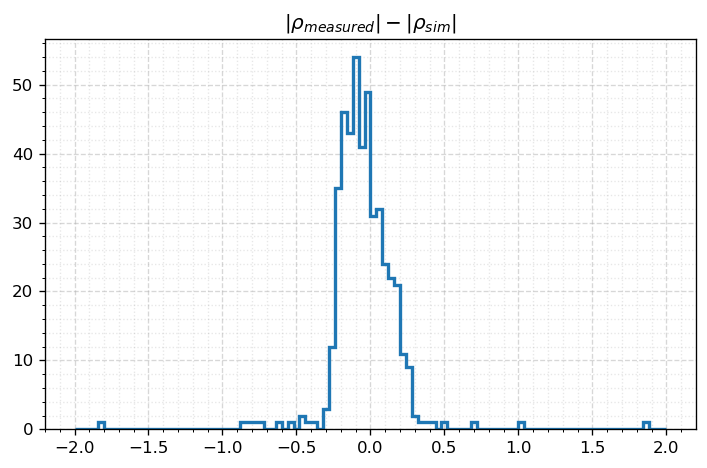

In [45]:
dlt = np.abs(dd.trho) - np.abs(dd.rho)
plt.hist(dlt, bins=100, range=(-2, 2), histtype='step', lw=2)
pys.my_style('$|\\rho_{measured}| - |\\rho_{sim}|$')

In [46]:
gauss = pyfit.FitGauss()
f = pyfit.Fitter(dlt, gauss, {'n_sig': 100, 'm': 0, 's': 1}, {'n_sig': (0, None), 'm': (-1, 1), 's': (0.1, None)}, fit_range=(-1, 1))

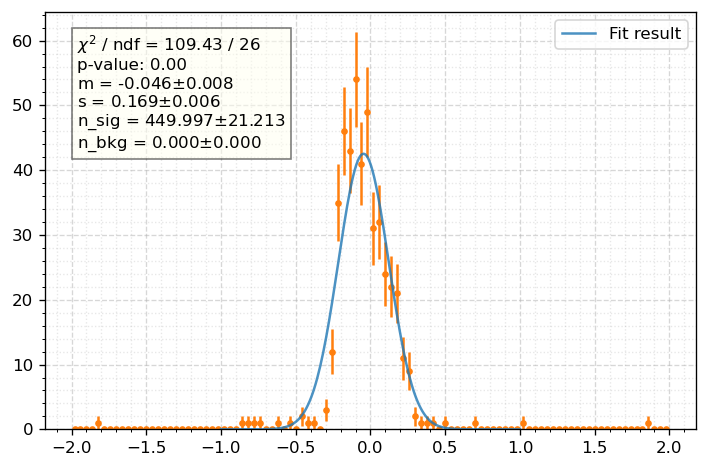

In [47]:
f.fit()
f.plot((-2, 2), 100)

Получаю разрешение по $\rho$

In [8]:
rho_resolution = f.m.values['s']
print(f'Разрешение по rho: {rho_resolution:.2f} см')

Разрешение по rho: 0.17 см


Математическое обоснование систематики:
$$
    \sigma_f^2 = {\bigg(\frac{\partial f}{\partial \rho} \bigg)}^2 \sigma_\rho^2 \sim {\bigg(\frac{f(\rho + \sigma_\rho) - f(\rho)}{\sigma_\rho} \bigg)}^2 \sigma_\rho^2 = \big( f(\rho + \sigma_\rho) - f(\rho) \big)^2 = \Delta^2(\sigma_\rho)
$$

$$
    \sigma_f^2 = {\bigg(\frac{\partial f}{\partial \rho} \bigg)}^2 \sigma_\rho^2 \sim {\bigg(\frac{f(\rho + \sigma_\rho/2) - f(\rho)}{\sigma_\rho/2} \bigg)}^2 \sigma_\rho^2 = 4 \cdot \big( f(\rho + \sigma_\rho/2) - f(\rho) \big)^2 = 4 \cdot \Delta^2(\sigma_\rho/2)
$$

Отсюда видно, что для уменьшения влияния статистики нужно использовать несколько сдвигов и делать аппроксимацию

$$
    \big( \sigma_f \cdot x \big)^2 = \Delta^2(\sigma_\rho \cdot x)
$$

$$
\Delta(\sigma_\rho \cdot x) = N_{exp}(\rho + \sigma_\rho \cdot x)/N_{MC}(\rho + \sigma_\rho \cdot x) - N_{exp}(\rho)/N_{MC}(\rho)
$$

Проблема в том, что $N_{exp}(\rho + \sigma_\rho \cdot x)$ и $N_{exp}(\rho)$ закоррелированы (с MC то же самое), поэтому логично взять независимые переменные: 

$$
N_{exp}(\rho) = N_{exp}(\rho + \sigma_\rho \cdot x) + dN_{exp}(\sigma_\rho \cdot x)
$$ 

т.е. $N_{exp}(\rho + \sigma_\rho \cdot x)$ и $dN_{exp}(\sigma_\rho \cdot x)$, которые обозначаю $\tilde{N}_{exp}$ и $d\tilde{N}_{exp}$ соответственно

$$
\Delta(\sigma_\rho \cdot x) = \frac{\tilde{N}_{exp}}{\tilde{N}_{MC}} - \frac{\tilde{N}_{exp} + d\tilde{N}_{exp}}{\tilde{N}_{MC} + d\tilde{N}_{MC}} = \frac{\tilde{N}_{exp}}{\tilde{N}_{MC}} \big( 1 - \frac{1 + d\tilde{N}_{exp}/\tilde{N}_{exp}}{1 + d\tilde{N}_{MC}/\tilde{N}_{MC}}  \big)
$$

In [9]:
SEASON='19'
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False, z_cut=12, align_cut=0.8)
df_mc = preprocess.read_tree(mc_tree, mc=True, z_cut=12, align_cut=0.8)

In [29]:
rho_cutter = lambda df, rcut: df.loc[(np.abs(df['trho[0]'])>rcut)&(np.abs(df['trho[1]'])>rcut)].copy()

def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM

def rho_sys(e0, rho_cut=0.1):
    fit_range = (-40, 20)
    params = {
    'n_sig' : 2000, 'm' : 0, 'sL' : 2, 'sR' : 4, 'aL' : 0.1, 'aR' : 0.1, 'y0' : 0.1, 'dy' : 0.1
    }
    lims = {
        'n_sig' : (0, None), 'm' : (-10, 10), 'sL' : (0.5, None), 'sR' : (0.5, None), 'aL' : (0, None), 'aR' : (0, None), 
        'y0' : (0, 0), 'dy' : (0, 0) 
    }
    dfE, dfM = get_x1(rho_cutter(df_exp, rho_cut), rho_cutter(df_mc, rho_cut), e0)
    dataE, dataM = dfE.x1.values, dfM.x1.values
    foo = pyfit.Fit1(fit_range)
    
    f_mc = pyfit.Fitter(dataM, foo, params, lims, fit_range)
    f_mc.fit()
    
    f_exp = pyfit.Fitter(dataE, foo, f_mc.get_params(), f_mc.get_limits(3, {'y0': (0, None), 'dy': (0, None)}), 
                         fit_range)
    f_exp.fit()
    
#     val = f_exp.m.values['n_sig']/f_mc.m.values['n_sig']
#     err = val*np.sqrt( (f_exp.m.errors['n_sig']/f_exp.m.values['n_sig'])**2 + (f_mc.m.errors['n_sig']/f_mc.m.values['n_sig'])**2 )
    return (f_exp.m.values['n_sig'], f_mc.m.values['n_sig'])

In [30]:
e0 = 800
cuts = np.linspace(0.1, 0.4, 50)
# cuts = np.linspace(12, 8, 40)
vals = np.array([rho_sys(e0, cut) for cut in cuts])

x = ((cuts - cuts[0])/rho_resolution)[1:]

Ne, Nm = vals[1:].T
dNe, dNm = (vals[0] - vals[1:]).T
dNe, dNm = np.where(dNe<0, 0, dNe), np.where(dNm<0, 0, dNm)
N, M = 1 + dNe/Ne, 1 + dNm/Nm
delta0 = np.abs(1 - N/M)
delta0_err = (N/M)*np.sqrt(
    (dNe/Ne/N)**2 * ( 1/Ne + 1/dNe ) + (dNm/Nm/M)**2 * ( 1/Nm + 1/dNm )
)

In [31]:
n0 = 200
Ne_ext = np.array([np.random.poisson(x, n0) for x in Ne])
Nm_ext = np.array([np.random.poisson(x, n0) for x in Nm])
dNe_ext = np.array([np.random.poisson(x, n0) for x in dNe])
dNm_ext = np.array([np.random.poisson(x, n0) for x in dNm])

In [32]:
N_ext, M_ext = 1 + dNe_ext/Ne_ext, 1 + dNm_ext/Nm_ext
delta0_ext = np.abs(1 - N_ext/M_ext)

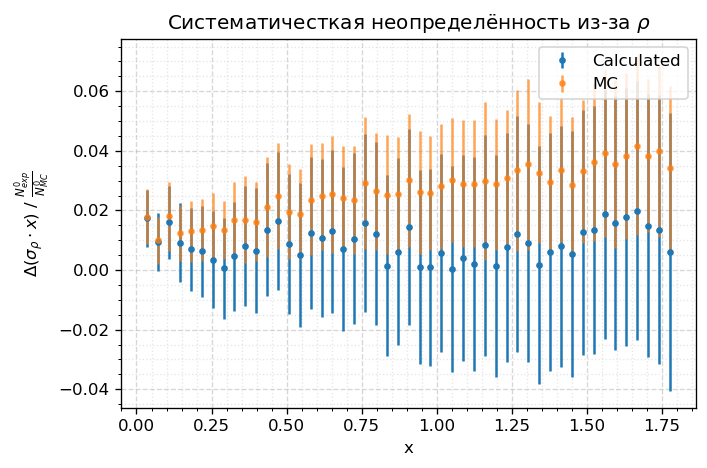

In [33]:
plt.errorbar(x, delta0, yerr=delta0_err, fmt='.', label='Calculated')
plt.errorbar(x, delta0_ext.mean(axis=1), yerr=delta0_ext.std(axis=1), fmt='.', alpha=0.7, label='MC')
pys.my_style('Систематичесткая неопределённость из-за $\\rho$', 'x', '$\\Delta(\\sigma_\\rho \cdot x)$ / $\\frac{N_{exp}^0}{N_{MC}^0}$',
            legend=True)

Эта неопределённость должна подгоняться прямой, коэффициент наклона которой отражает системати

In [34]:
line = lambda x, k: k*x
cost = iminuit.cost.LeastSquares(x, delta0_ext.mean(axis=1), delta0_ext.std(axis=1), line)
m0 = iminuit.Minuit(cost, k=0.004)
m0.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 12.75                      │              Nfcn = 13               │
│ EDM = 3.58e-15 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │  0.0279   │  0.0032   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        k │
├───┼──────────┤
│ k │ 1.03e-05 │
└───┴──────────┘

In [35]:
y0 = [cost.model(c, *m0.values) for c in x]

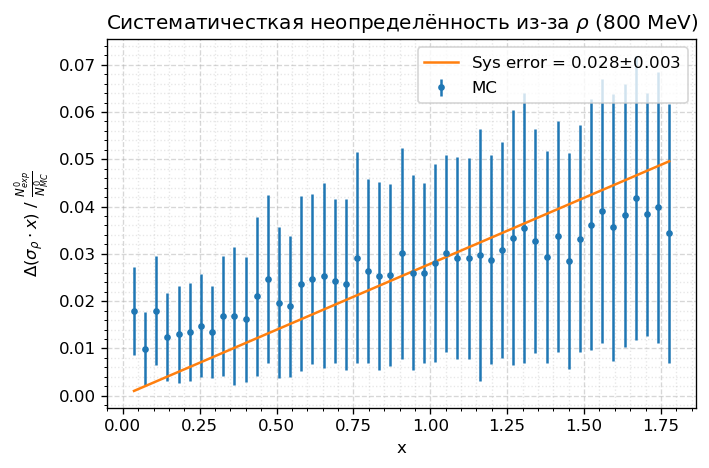

In [36]:
# plt.errorbar(x, delta0, yerr=delta0_err, fmt='.', label='Calculated')
plt.errorbar(x, delta0_ext.mean(axis=1), yerr=delta0_ext.std(axis=1), fmt='.', label='MC')
plt.plot(x, y0, label=f'Sys error = {m0.values["k"]:.3f}$\pm${m0.errors["k"]:.3f}')
pys.my_style(f'Систематичесткая неопределённость из-за $\\rho$ ({e0} MeV)', 
             'x', '$\\Delta(\\sigma_\\rho \cdot x)$ / $\\frac{N_{exp}^0}{N_{MC}^0}$', legend=True)

**Вопрос** что означал бы сдвиг фита, если бы я проводил его не из начала координат

Теперь напишу функцию, которая проходит по всем энергиям

In [72]:
import warnings 

def rho_sys_complex(e0=550, rho_resolution=0.17):
    cuts = np.linspace(0.1, 0.4, 20)
    with warnings.catch_warnings(record=True) as w:
        vals = []
        for cut in cuts:
            vals.append(rho_sys(e0, cut))
        vals = np.array(vals)
        if len(w) > 0:
            print('pass')
            return None
    x = ((cuts[1:] - cuts[0])/rho_resolution)
    Ne_vals, Nm_vals = vals[1:].T
    dNe_vals, dNm_vals = (vals[0] - vals[1:]).T
    
    n0 = 200
    Ne = np.array([np.random.poisson(x, n0) for x in np.clip(Ne_vals, 0, None)])
    Nm = np.array([np.random.poisson(x, n0) for x in np.clip(Nm_vals, 0, None)])
    dNe = np.array([np.random.poisson(x, n0) for x in np.clip(dNe_vals, 0, None)])
    dNm = np.array([np.random.poisson(x, n0) for x in np.clip(dNm_vals, 0, None)])
    
    with warnings.catch_warnings(record=True) as w:
        N, M = 1 + dNe/Ne, 1 + dNm/Nm
        delta0 = np.abs(1 - N/M)
        if len(w) > 0:
            print('pass2')
            return None
    line = lambda x, k: k*x        
    cost = iminuit.cost.LeastSquares(x, delta0.mean(axis=1), delta0.std(axis=1), line)
    m0 = iminuit.Minuit(cost, k=0.004)
    m0.migrad()
    return (m0.values['k'], m0.errors['k'])

In [73]:
res = {}
for e in (df_mc.index.unique().intersection(df_mc.index.unique())):
    val = rho_sys_complex(e, rho_resolution)
    if val is not None:
        res[e] = val
    print(e)

537.5
787.5
550.0
800.0
562.5
812.5
575.0
825.0
587.5
837.5
600.0
850.0
612.5
862.5
625.0
875.0
637.5
887.5
641.0
pass2
900.0
650.0
912.5
662.5
pass2
925.0
675.0
936.0
687.5
945.0
700.0
950.0
712.5
951.1
725.0
955.0
737.5
962.5
750.0
975.0
762.0
pass2
978.0
775.0
987.5


In [74]:
ens = np.array(list(res.keys()))
sys = np.array(list(res.values()))

In [75]:
line = lambda x, k, b: k*(x-525) + b
cost = iminuit.cost.LeastSquares(ens, sys[:, 0], sys[:, 1], line)
m_t = iminuit.Minuit(cost, k=0.1, b=0.1)
m_t.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 286.9                      │              Nfcn = 35               │
│ EDM = 2.67e-16 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │ 0.091e-3  │ 0.010e-3  │            │            │         │         │       │
│ 1 │ b    │  0.0284   │  0.0020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │         k         b │
├───┼─────────────────────┤
│ k │  1.09e-10 -1.67e-08 │
│ b │ -1.67e-08  4.08e-06 │
└───┴─────────────────────┘

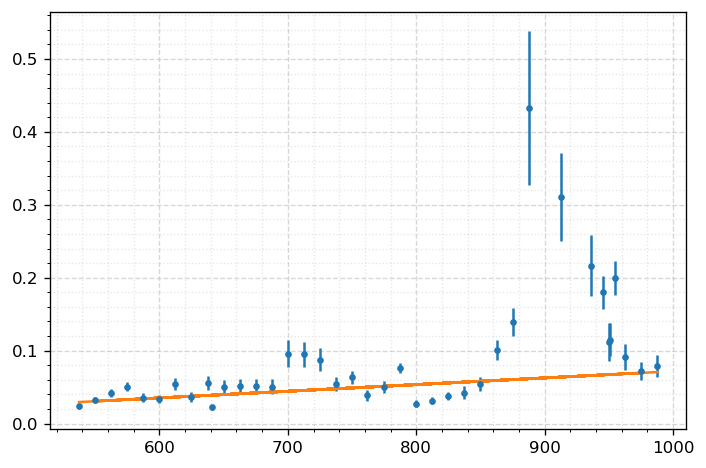

In [81]:
plt.errorbar(ens, sys[:, 0], yerr=sys[:, 1], fmt='.')
yy = [cost.model(en, *m_t.values) for en in ens]
plt.plot(ens, yy)
# plt.xlim(500, 800)
# plt.ylim(0, 0.12)
pys.my_style()

In [10]:
z_cutter = lambda df, zcut: df.loc[(np.abs(df['tz[0]'])<zcut)&(np.abs(df['tz[1]'])<zcut)].copy()

def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM

def z_sys(e0, z_cut=0.1):
    fit_range = (-40, 20)
    params = {
    'n_sig' : 2000, 'm' : 0, 'sL' : 2, 'sR' : 4, 'aL' : 0.1, 'aR' : 0.1, 'y0' : 0.1, 'dy' : 0.1
    }
    lims = {
        'n_sig' : (0, None), 'm' : (-10, 10), 'sL' : (0.5, None), 'sR' : (0.5, None), 'aL' : (0, None), 'aR' : (0, None), 
        'y0' : (0, 0), 'dy' : (0, 0) 
    }
    dfE, dfM = get_x1(z_cutter(df_exp, z_cut), z_cutter(df_mc, z_cut), e0)
    dataE, dataM = dfE.x1.values, dfM.x1.values
    foo = pyfit.Fit1(fit_range)
    
    f_mc = pyfit.Fitter(dataM, foo, params, lims, fit_range)
    f_mc.fit()
    
    f_exp = pyfit.Fitter(dataE, foo, f_mc.get_params(), f_mc.get_limits(3, {'y0': (0, None), 'dy': (0, None)}), 
                         fit_range)
    f_exp.fit()
    
#     val = f_exp.m.values['n_sig']/f_mc.m.values['n_sig']
#     err = val*np.sqrt( (f_exp.m.errors['n_sig']/f_exp.m.values['n_sig'])**2 + (f_mc.m.errors['n_sig']/f_mc.m.values['n_sig'])**2 )
    return (f_exp.m.values['n_sig'], f_mc.m.values['n_sig'])

In [57]:
fit_range = (-40, 20)
params = {
    'n_sig' : 2000, 'm' : 0, 'sL' : 2, 'sR' : 4, 'aL' : 0.1, 'aR' : 0.1, 'y0' : 0.1, 'dy' : 0.1
}
lims = {
    'n_sig' : (0, None), 'm' : (-10, 10), 'sL' : (0.5, None), 'sR' : (0.5, None), 'aL' : (0, None), 'aR' : (0, None), 
    'y0' : (0, None), 'dy' : (0, None) 
}

In [52]:
rho_cut, e0 = 0.2, 550
dfE, dfM = get_x1(rho_cutter(df_exp, rho_cut), rho_cutter(df_mc, rho_cut), e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

In [56]:
foo = pyfit.Fit1(fit_range)

In [64]:
f = pyfit.Fitter(dataM, foo, params, lims, fit_range)

In [65]:
f.fit()

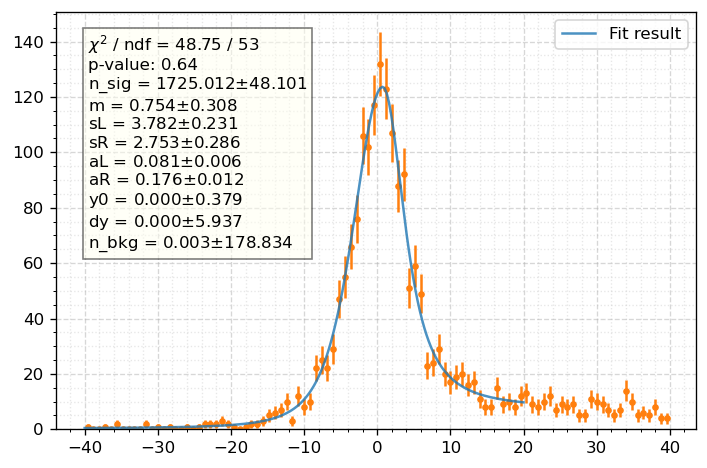

In [66]:
f.plot((-40, 40), 100)

In [4]:
data = df_exp.loc[550].x1

In [5]:
fit_range = (-40, 20)
width = fit_range[1] - fit_range[0]
fitf = lambda x, n_sig, m, sL, sR, aL, aR, y0, dy: ( n_sig + width*(2*y0+dy)/2, \
                                                    pyfit.pdf(x, n_sig, m, sL, sR, aL, aR, y0, dy, fit_range))

In [30]:
pars = {'n_sig': 100, 'm': 0, 'sL': 1, 'sR' : 1, 'aL' : 1, 
                             'aR' : 1, 'y0' : 0, 'dy' : 0}
lims = {'n_sig': (0, None), 'm': (-10, 10), 'sL': (1, 10), 
                  'sR' : (1,10), 'aL' : (0, None), 'aR' : (0, None), 
                  'y0' : (0,5), 'dy' : (0, 4)}
sigmas = {'m': 0.5}

In [31]:
f = pyfit.Fitter(data, fitf, pars, lims, (-40, 20), sigmas)

In [47]:
f.get_params()

{'n_sig': 405.27453607495147,
 'm': -0.8376351697998956,
 'sL': 4.6940827769093225,
 'sR': 2.506810046114845,
 'aL': 0.043547569309800194,
 'aR': 0.15805395519763366,
 'y0': 9.195044989307455e-07,
 'dy': 1.4247012770721923}

In [32]:
f.fit()

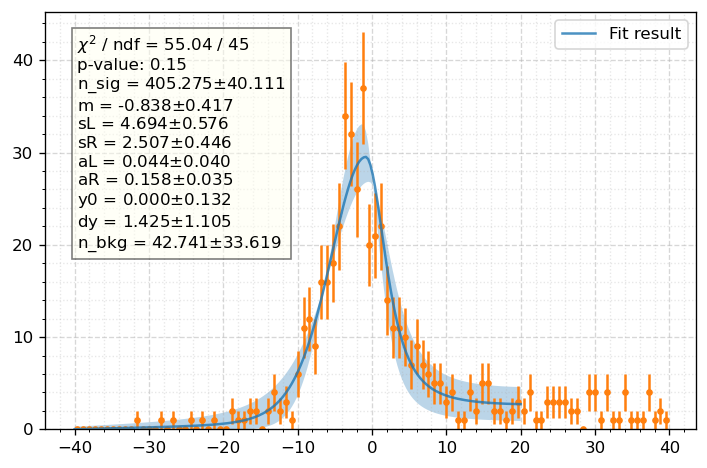

In [33]:
f.plot((-40, 40), 100, fill_errors=True)

In [25]:
def fitf(**kwargs):
    x, n_sig, m = kwargs['x'], kwargs['n_sig'], kwargs['m']
    sL, sR, aL, aR = kwargs['sL'], kwargs['sR'], kwargs['aL'], kwargs['aR']
    y0, dy = kwargs['y0'], kwargs['dy']
    fit_range = kwargs['fit_range']
    width = fit_range[1] - fit_range[0]
    return ( n_sig + width*(2*y0+dy)/2, pyfit.pdf(x, n_sig, m, sL, sR, aL, aR, y0, dy, fit_range))

In [4]:
e0 = 550

$|\rho| < 0.1$ - стандарт

In [22]:
fit_range = (-40, 20)
params = {
    'n_sig': (2000, (0.1, None)),
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'y0'   : (   0.1, (0, None)),
    'dy'   : (   0.1, (0, None)),
}

dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse();
params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse();

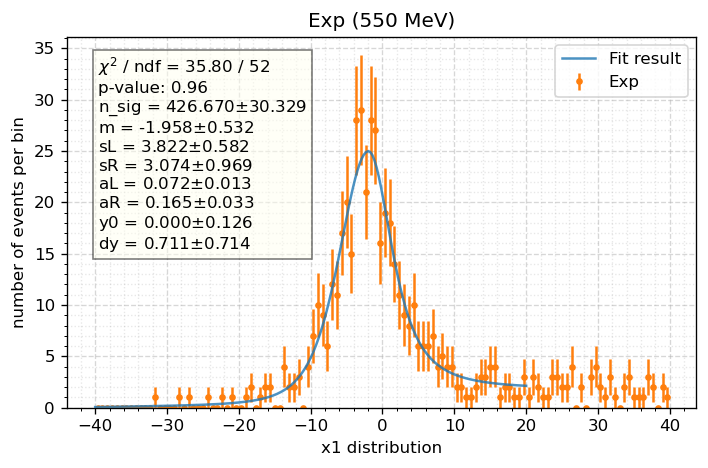

In [23]:
hist_range=(-40, 40)
def plot_fit_data(save=False):
#     pys.plot_fit(dataM, cost_mc, m_mc, 120, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution', alpha=0.8,
#                ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)#, bbox_color=None, fit_color='#CC6FD9', data_color='#9AD9C8')
# #     plt.grid(ls=':', alpha=0.2)
#     if save:
#         if not(os.path.isdir(f'images/fit{SEASON}')):
#             os.mkdir(f'images/fit{SEASON}')
#         plt.savefig(f'images/fit{SEASON}/mc_{e0}.png', dpi=120)

    pys.plot_fit(dataE, cost_exp, m_exp, 120, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution', alpha=0.8,
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True, fill_errors=False)#, bbox_color=None, fit_color='#CC6FD9', data_color='#8C7B48')
#     plt.grid(alpha=0.2)
    if save:
        plt.savefig(f'images/fit{SEASON}/exp_{e0}.png', dpi=120)
plot_fit_data(False)

In [24]:
val0 = m_exp.values['n_sig']/m_mc.values['n_sig']

$|\rho| > 0.2$

In [20]:
rho_cutter = lambda df, rcut: df.loc[(np.abs(df['trho[0]'])>rcut)&(np.abs(df['trho[1]'])>rcut)].copy()

fit_range = (-40, 20)
params = {
    'n_sig': (2000, (0.1, None)),
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'y0'   : (   0.1, (0, None)),
    'dy'   : (   0.1, (0, None)),
}

dfE, dfM = get_x1(rho_cutter(df_exp, 0.22), rho_cutter(df_mc, 0.22), e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse();
params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse();

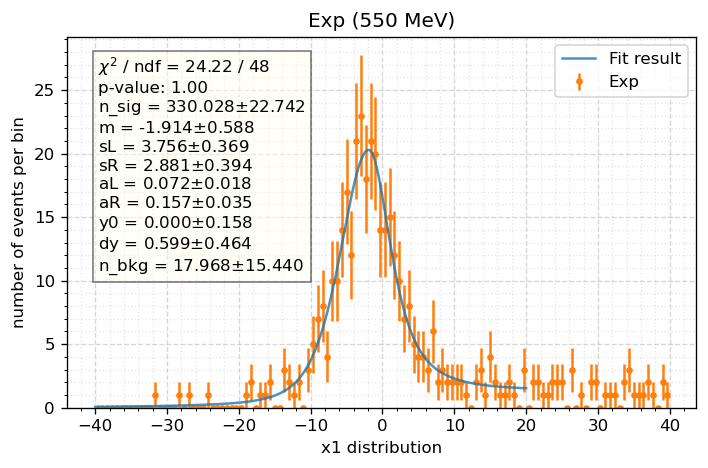

In [53]:
plot_fit_data(False)

In [54]:
val1 = m_exp.values['n_sig']/m_mc.values['n_sig']

In [55]:
(val0 - val1)/val0/np.sqrt(2)

-0.004465173727025293

In [26]:
xx = np.linspace(0.1, 0.4, 30)
yy = [(rho_sys(x) - val0)/val0 for x in xx]

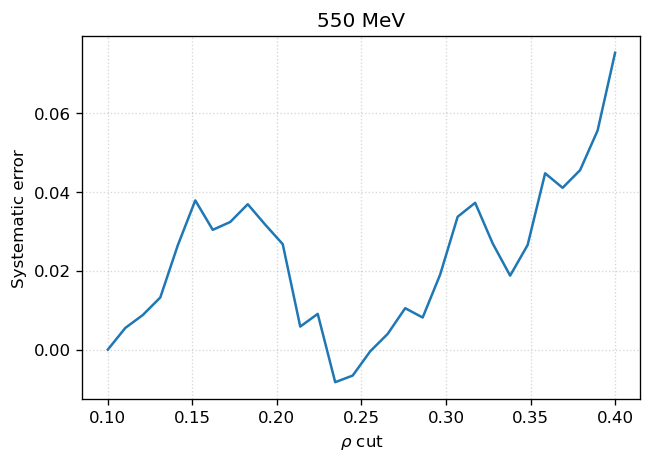

In [58]:
plt.plot(xx, yy)
plt.grid(ls=':', alpha=0.5);
plt.title(f'{e0} MeV')
plt.ylabel('Systematic error')
plt.xlabel('$\\rho$ cut');

In [6]:
# SEASON='11'
mc_tree = uproot.open('/spoolA/petrov/remove/tr_ph_kskl_550_70260.root')['tr_ph']
# df_mc0 = preprocess.read_tree(mc_tree, mc=True, z_cut=12, align_cut=0.8)

In [7]:
mc_tree.arrays(['simvtx', 'simvty', 'simorig', 'simtype'], library='pd').query('(simorig==310)&(simtype==211)')

,,simvtx,simvty,simorig,simtype
entry,subentry,,,,
5,1,-0.241353,0.230197,310,211
6,1,-1.180101,-1.007905,310,211
7,1,-0.084794,-0.191736,310,211
8,1,-0.418221,0.337711,310,211
9,1,-0.184470,-0.082129,310,211
...,...,...,...,...,...
994,1,-2.072619,-1.496358,310,211
995,1,-0.619908,0.097878,310,211
996,1,-0.328234,-0.011713,310,211


In [8]:
df_tracks = mc_tree.arrays(['trho', 'tcharge', 'nt'], library='pd').query('(tcharge>0)&(nt==2)')

In [11]:
df_sim = mc_tree.arrays(['simvtx', 'simvty', 'simorig', 'simtype', 'simphi'], library='pd').query('((simtype)==211)&(simorig==310)')
df_sim['simrho'] = np.sqrt( df_sim['simvtx']**2 + df_sim['simvty']**2)
df_sim['tg'] = np.tan(df_sim['simphi'])
df_sim['b'] = df_sim['simvty'] - df_sim['tg']*df_sim['simvtx']
df_sim['rho'] = (df_sim['b']/np.sqrt(df_sim['tg']**2 + 1))

In [12]:
dd = df_tracks.reset_index().drop(['subentry'], axis=1).set_index('entry').join(df_sim.reset_index().drop(['subentry'], axis=1).set_index('entry'))
dd.dropna(inplace=True)
dd.head()

,trho,tcharge,nt,simvtx,simvty,simorig,simtype,simphi,simrho,tg,b,rho
entry,,,,,,,,,,,,
6,-1.025506,1,2,-1.180101,-1.007905,310.0,211.0,4.692548,1.551938,50.393608,58.461628,1.159872
7,0.045361,1,2,-0.084794,-0.191736,310.0,211.0,5.042944,0.209649,-2.914215,-0.438846,-0.142435
9,0.111370,1,2,-0.184470,-0.082129,310.0,211.0,1.045300,0.201927,1.724485,0.235987,0.118381
11,-0.052003,1,2,0.439890,-0.251762,310.0,211.0,2.779448,0.506840,-0.378854,-0.085108,-0.079588
12,0.203331,1,2,0.350926,-0.598515,310.0,211.0,5.194852,0.693808,-1.909323,0.071515,0.033180


In [136]:
# dlt = np.abs(dd.trho) - np.abs(dd.simrho)
# plt.hist(dlt, bins=100, range=(-2, 2), histtype='step', lw=2)
# pys.my_style('$|\\rho_{measured}| - |\\rho_{sim}|$')

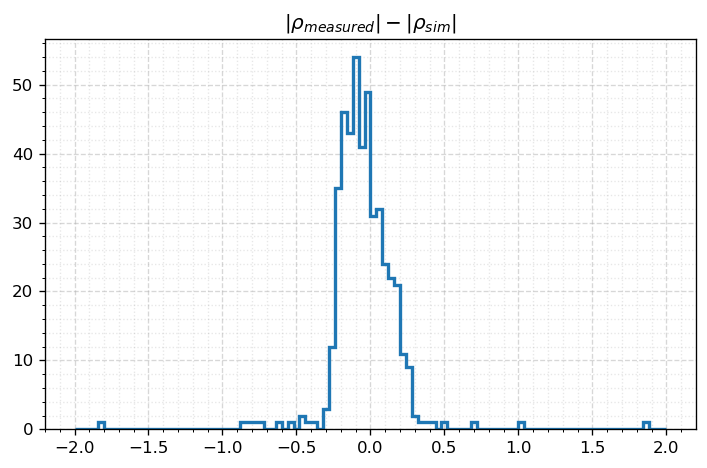

In [138]:
dlt = np.abs(dd.trho) - np.abs(dd.rho)
plt.hist(dlt, bins=100, range=(-2, 2), histtype='step', lw=2)
pys.my_style('$|\\rho_{measured}| - |\\rho_{sim}|$')

In [139]:
dlt[np.abs(dlt)<1].std()

0.1690005213022232

In [69]:
class GFit():
    def __init__(self):
        pass
    def __call__(self, x, m, s, n_sig):
        return (n_sig, n_sig*np.exp( -(x - m)**2/2/(s**2))/np.sqrt(2*np.pi*(s**2)))
    def get_nsig(self, minuit):
        return (minuit.values['n_sig'], minuit.errors['n_sig'])
    def get_nbkg(self, minuit):
        return (0, 0)

In [132]:
gauss = GFit()
f = pyfit.Fitter(dlt, gauss, {'n_sig': 100, 'm': 0, 's': 1}, {'n_sig': (0, None), 'm': (-1, 1), 's': (0.1, None)}, fit_range=(-1, 1))

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -4922                      │              Nfcn = 193              │
│ EDM = 6.8e-08 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m     │  -0.046   │   0.008   │            │            │   -1    │    1    │       │
│ 1 │ s     │   0.169   │   0.006   │            │            │   0.1   │         │       │
│ 2 │ n_sig │    450    │    21     │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         m         s     n_sig │
├───────┼───────────────────────────────┤
│     m │  6.33e-05  5.12e-08 -1.24e-09 │
│     s │  5.12e-08  3.17e-05 -1.08e-09 │
│ n_sig │ -1.24e-09 -1.08e-09       450 │
└───────┴───────────────────────────────┘

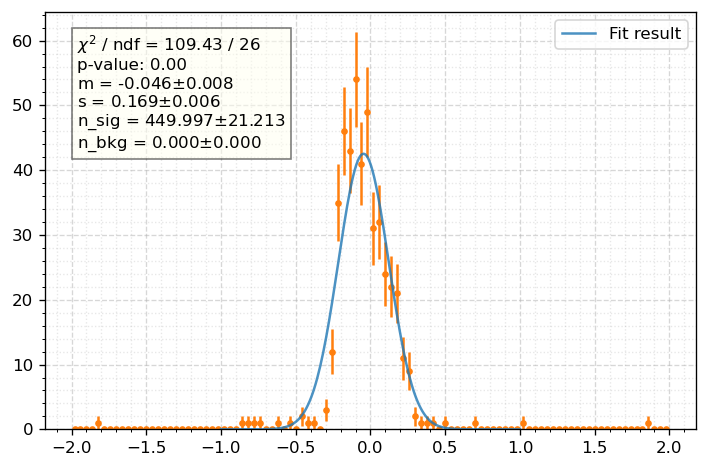

In [92]:
xx1 = np.linspace(0.1, 0.6, 50)
yy1 = [rho_sys(x) for x in xx1]
get_rho_sys = lambda x0: np.interp(x0, xx1, yy1)

In [94]:
get_rho_sys_per = lambda x0: (get_rho_sys(x0+0.17) - get_rho_sys(x0))/get_rho_sys(x0)

In [106]:
xx2 = np.linspace(0.1, 0.35, 160)
yy2 = [get_rho_sys_per(x) for x in xx2]

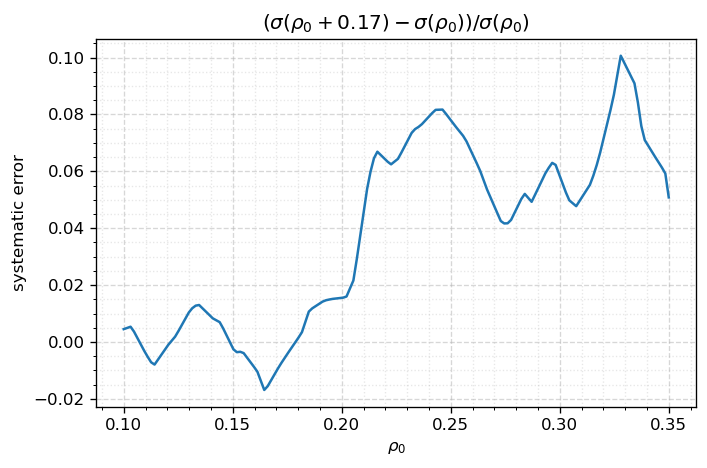

In [124]:
plt.plot(xx2, yy2)
pys.my_style('$(\\sigma(\\rho_0+0.17) - \\sigma(\\rho_0))/\\sigma(\\rho_0)$', '$\\rho_0$', 'systematic error')

Взять 4pi

посмотреть диапазоны импульсов пионов, сравнить с диапазонами 4 pi